In [48]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cvxopt
import yfinance as yf
import pypfopt
from pypfopt import risk_models
from pypfopt import plotting
from pypfopt import expected_returns
from pypfopt import EfficientFrontier
from pypfopt import DiscreteAllocation
from pypfopt import objective_functions
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
import datetime


# getStockPrice
def getStockPrice(stocks):
    end_date = pd.Timestamp.now()
    start_date = end_date - pd.DateOffset(years=5)
    raw = yf.download(stocks, start=start_date, end="2023-06-12")
    prices = raw["Adj Close"].dropna(how="all")
    # Add cash into the dataset
    # prices['cash'] = 1

    # Copy last year data to achieve 1.5x weight
    # Add weights
    #recent_year = end_date - pd.DateOffset(years=1)
    #recent_data = prices[prices.index >= recent_year]
    #weighted_prices = pd.concat([prices, recent_data, recent_data * 0.5])

    return prices.dropna()


# Plot the stock price if needed
def plotStockPrice(prices):
    prices[prices.index >= "2008-01-01"].plot(figsize=(15, 10))
    return 0


# Compute the expected return
def estimateReturn(prices):
    return expected_returns.capm_return(prices)


# Compute the covariance matrix
def covarianceMatrix(prices):
    # plotting.plot_covariance(S, plot_correlation=True)
    return risk_models.CovarianceShrinkage(prices).ledoit_wolf()


# Predict price using random forest
def predict_prices_rf(prices):
    # For each stock, create a Random Forest model and predict the price for next 20 days
    predicted_prices = pd.DataFrame(index=range(len(prices.index) + 20))
    for stock in prices.columns:
        X = np.array(range(len(prices[stock]))).reshape(-1, 1)
        y = prices[stock].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        regr = RandomForestRegressor(max_depth=2, random_state=0)
        regr.fit(X_train, y_train)

        # Predict for next 20 days
        future = np.array(range(len(prices[stock]), len(prices[stock]) + 20)).reshape(-1, 1)
        for day in future:
            X_day = day.reshape(1, -1)
            predicted = regr.predict(X_day)
            y = np.concatenate((y, predicted))
            X = np.concatenate((X, X_day))
            regr.fit(X, y)  # retrain the model with the predicted value
        predicted_prices[stock] = y
    return predicted_prices


# SVM
def predict_prices_svm(prices):
    predicted_prices = pd.DataFrame(index=range(len(prices.index) + 20))
    for stock in prices.columns:
        X = np.array(range(len(prices[stock]))).reshape(-1, 1)
        y = prices[stock].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        svm = SVR(kernel='rbf')
        svm.fit(X_train, y_train)

        # Predict for next 20 days
        future = np.array(range(len(prices[stock]), len(prices[stock]) + 20)).reshape(-1, 1)
        for day in future:
            X_day = day.reshape(1, -1)
            predicted = svm.predict(X_day)
            y = np.concatenate((y, predicted))
            X = np.concatenate((X, X_day))
            svm.fit(X, y)  # retrain the model with the predicted value
        predicted_prices[stock] = y
    return predicted_prices


# Decision Tree
def predict_prices_dt(prices):
    # For each stock, create a Decision Tree Regression model and predict the price for the next 20 days
    predicted_prices = pd.DataFrame(index=range(len(prices.index) + 20))
    for stock in prices.columns:
        X = np.array(range(len(prices[stock]))).reshape(-1, 1)
        y = prices[stock].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        regr = DecisionTreeRegressor(max_depth=2, random_state=0)
        regr.fit(X_train, y_train)

        # Predict for the next 20 days
        future = np.array(range(len(prices[stock]), len(prices[stock]) + 20)).reshape(-1, 1)
        for day in future:
            X_day = day.reshape(1, -1)
            predicted = regr.predict(X_day)
            y = np.concatenate((y, predicted))
            X = np.concatenate((X, X_day))
            regr.fit(X, y)  # retrain the model with the predicted value
        predicted_prices[stock] = y

    return predicted_prices


# Print the best result and save to the txt file
def printResult(model, st, er, w):
    print("The best ML approach is:")
    print(model)
    print("The best sharpe ratio is: ")
    print(st)
    print("The expected return is: ")
    print(er)
    print("The weight for each stock is: ")
    print(w)
    pd.Series(w).plot.pie(figsize=(10, 10), autopct='%1.5f%%')
    plt.savefig('portfolio_pie_chart_' + model + '.png')
    current_date = datetime.date.today()
    file_name = f"../Result/{current_date}.txt"
    with open(file_name, "a") as file:
        file.write("Mean Variance Optimization: \nUse {" + model + '}, sharpe ratio = ' + str(st) +
                   ', expected return = {' + str(er) + '}, weight: ' + str(w) + "\n")




In [76]:
def sharpeRatioMax(prices, sector_mapper, sector_lower, sector_upper):
    mu = estimateReturn(prices)
    S = covarianceMatrix(prices)

    best_gamma = None
    best_sharpe = None
    best_weight = None
    best_volatility = None
    best_expected_return = None

    for gamma in np.arange(0, 1, 0.1):
        ef = EfficientFrontier(mu, S)
        #ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
        # Each stock should have ratio between 5% and 10%
        ef.add_constraint(lambda w: w <= 0.10)
        ef.add_constraint(lambda w: w >= 0.05)
        #ef.add_objective(objective_functions.L2_reg, gamma=gamma)  # gamma is the tuning parameter
        # ef.efficient_risk(0.18)
        #ef.max_sharpe()  # Maximum the sharpe ratio
        ef.min_volatility()
        weights = ef.clean_weights()
        expected_return, volatility, sharpe_ratio = ef.portfolio_performance(verbose=False)

        if best_sharpe is None or sharpe_ratio > best_sharpe:
            best_gamma = gamma
            best_sharpe = sharpe_ratio
            best_weight = weights
            best_volatility = volatility
            best_expected_return = expected_return
    return best_sharpe, best_expected_return, best_weight

In [50]:

# Step 1: define variables
stocks = ['PFE', 'COST', 'AMZN', 'GOOGL', 'MRK', 'TSLA', 'LMT', 'BSX', 'HSBC', 'MSFT', 'CVX', 'MCD', 'AAPL',
          'GS', 'CI', 'NVDA']
sector_mapper = {
    "AAPL": "Tech",
    "AMZN": "Consumer Discretionary",
    "BSX": "Healthcare",
    "CI": "Healthcare",
    "COST": "Consumer Staples",
    "CVX": "Energy",
    "GOOGL": "Tech",
    "GS": "Financial Services",
    "HSBC": "Financial Services",
    "LMT": "Aerospace",
    "MCD": "Consumer Staples",
    "MRK": "Healthcare",
    "MSFT": "Tech",
    "PFE": "Healthcare",
    "TSLA": "Auto",
    "cash": "cash"
}

sector_lower = {"cash": 0.08}

sector_upper = {"cash": 0.15}
# Step 2: get stock price history data
prices = getStockPrice(stocks)
# Step 3: Use different ML algorithm to predict the price until 06-30
# Random Forest
future_prices = predict_prices_rf(prices)

[*********************100%***********************]  16 of 16 completed


In [77]:
sharpe_ratio_rf, expected_returns_rf, weights_rf = sharpeRatioMax(future_prices, sector_mapper, sector_lower,
                                                                  sector_upper)

In [78]:
# SVM
future_prices = predict_prices_svm(prices)
sharpe_ratio_svm, expected_returns_svm, weights_svm = sharpeRatioMax(future_prices, sector_mapper, sector_lower,
                                                                     sector_upper)

In [79]:
# Decision Tree
future_prices = predict_prices_dt(prices)
sharpe_ratio_dt, expected_returns_dt, weights_dt = sharpeRatioMax(future_prices, sector_mapper, sector_lower,
                                                                  sector_upper)

The best ML approach is:
Random Forest
The best sharpe ratio is: 
0.8487450858235497
The expected return is: 
0.19555198593243464
The weight for each stock is: 
OrderedDict([('AAPL', 0.05), ('AMZN', 0.05), ('BSX', 0.05), ('CI', 0.05), ('COST', 0.07085), ('CVX', 0.05), ('GOOGL', 0.05), ('GS', 0.05), ('HSBC', 0.05), ('LMT', 0.1), ('MCD', 0.07915), ('MRK', 0.1), ('MSFT', 0.05), ('NVDA', 0.05), ('PFE', 0.1), ('TSLA', 0.05)])


FileNotFoundError: [Errno 2] No such file or directory: '../Result/2023-07-02.txt'

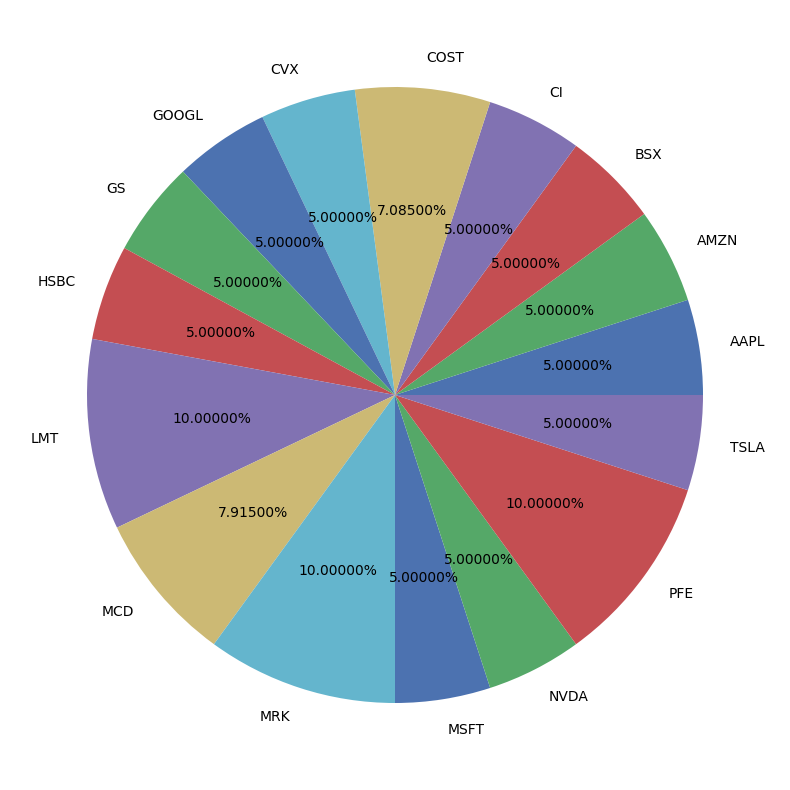

In [80]:
# Find the best sharpe ratio from three ML approaches
max_rt = max(sharpe_ratio_rf, sharpe_ratio_svm, sharpe_ratio_dt)
if max_rt == sharpe_ratio_rf:
    printResult("Random Forest", sharpe_ratio_rf, expected_returns_rf, weights_rf)
elif max_rt == sharpe_ratio_svm:
    printResult("SVM", sharpe_ratio_svm, expected_returns_svm, weights_svm)
else:
    printResult("Decision Tree", sharpe_ratio_dt, expected_returns_dt, weights_dt)